In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from lstm_baseline import LSTMModel
from sklearn.metrics import mean_squared_error


In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(1)

### Technical and Macro signals.

In [3]:
df = pd.read_csv("data_final.csv")
df = df.sort_values("observation_date")
df = df.reset_index(drop=True)

macro_features = [
    'FEDFUNDS',
    'UNRATE',
    'GS10',
    'DTWEXBGS',
    'DCOILWTICO',
    'GOLD',
    'MOVE',
    'VIXCLS'
]

technical_features = [
    'SMA_10',
    'SMA_50',
    'EMA_10',
    'EMA_50',
    'ROC_10',
    'RSI_14',
    'BB_upper',
    'BB_lower',
    'Volatility_20'
]

df['log_return'] = np.log(df['SP500'] / df['SP500'].shift(1))
df = df.dropna().reset_index(drop=True)

target = 'log_return'

X_macro = df[macro_features].values
y_macro = df[[target]].values
X_technical = df[technical_features].values
y_technical = df[[target]].values


In [4]:
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 20
X_macro_seq_raw, y_macro_seq_raw = create_sequences(X_macro, y_macro, seq_length)

def train_val_test_split(X, y, train_ratio=0.7, val_ratio=0.15):
    total = X.shape[0]
    train_end = int(total * train_ratio)
    val_end = int(total * (train_ratio + val_ratio))
    return X[:train_end], y[:train_end], X[train_end:val_end], y[train_end:val_end], X[val_end:], y[val_end:]

X_train_raw, y_train_raw, X_val_raw, y_val_raw, X_test_raw, y_test_raw = train_val_test_split(X_macro_seq_raw, y_macro_seq_raw)

macro_scaler = MinMaxScaler()
X_train_flat = X_train_raw.reshape(-1, X_train_raw.shape[-1])
X_train_scaled = macro_scaler.fit_transform(X_train_flat).reshape(X_train_raw.shape)
X_val_scaled = macro_scaler.transform(X_val_raw.reshape(-1, X_val_raw.shape[-1])).reshape(X_val_raw.shape)
X_test_scaled = macro_scaler.transform(X_test_raw.reshape(-1, X_test_raw.shape[-1])).reshape(X_test_raw.shape)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train_raw)
y_val_scaled = y_scaler.transform(y_val_raw)
y_test_scaled = y_scaler.transform(y_test_raw)

X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train_scaled, dtype=torch.float32)
X_val = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val = torch.tensor(y_val_scaled, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test = torch.tensor(y_test_scaled, dtype=torch.float32)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.linear(out)

input_size = X_train.shape[2]
model = LSTMModel(input_size=input_size, hidden_size=64, output_size=1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=16)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=16, shuffle=False)

train_losses, val_losses, test_losses = [], [], []

for epoch in range(200):
    model.train()
    total_train_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred.squeeze(), yb.squeeze())
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    train_losses.append(total_train_loss / len(train_loader))

    model.eval()
    with torch.no_grad():
        val_loss = sum(criterion(model(xb).squeeze(), yb.squeeze()).item() for xb, yb in val_loader) / len(val_loader)
        test_loss = sum(criterion(model(xb).squeeze(), yb.squeeze()).item() for xb, yb in test_loader) / len(test_loader)

    val_losses.append(val_loss)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}: Train={train_losses[-1]:.4f}, Val={val_loss:.4f}, Test={test_loss:.4f}")

torch.save(model, "lstm_model_macro_signals.pth")


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1: Train=0.2068, Val=0.1738, Test=0.2171
Epoch 2: Train=0.0197, Val=0.0460, Test=0.0555
Epoch 3: Train=0.0111, Val=0.0949, Test=0.1159
Epoch 4: Train=0.0102, Val=0.0750, Test=0.0874
Epoch 5: Train=0.0100, Val=0.0643, Test=0.0687
Epoch 6: Train=0.0094, Val=0.0505, Test=0.0504
Epoch 7: Train=0.0099, Val=0.0507, Test=0.0487
Epoch 8: Train=0.0095, Val=0.0471, Test=0.0433
Epoch 5: Train=0.0100, Val=0.0643, Test=0.0687
Epoch 6: Train=0.0094, Val=0.0505, Test=0.0504
Epoch 7: Train=0.0099, Val=0.0507, Test=0.0487
Epoch 8: Train=0.0095, Val=0.0471, Test=0.0433
Epoch 9: Train=0.0090, Val=0.0517, Test=0.0446
Epoch 10: Train=0.0086, Val=0.0302, Test=0.0199
Epoch 11: Train=0.0089, Val=0.0290, Test=0.0178
Epoch 12: Train=0.0090, Val=0.0363, Test=0.0237
Epoch 9: Train=0.0090, Val=0.0517, Test=0.0446
Epoch 10: Train=0.0086, Val=0.0302, Test=0.0199
Epoch 11: Train=0.0089, Val=0.0290, Test=0.0178
Epoch 12: Train=0.0090, Val=0.0363, Test=0.0237
Epoch 13: Train=0.0083, Val=0.0372, Test=0.0236
Epoch 

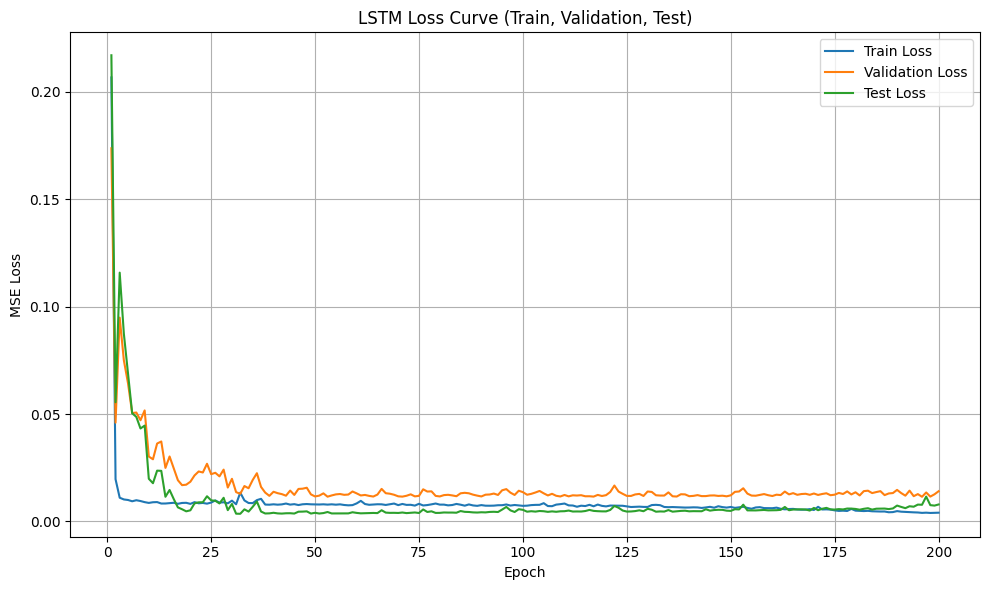

In [5]:
epochs = list(range(1, len(train_losses) + 1))
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.title("LSTM Loss Curve (Train, Validation, Test)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

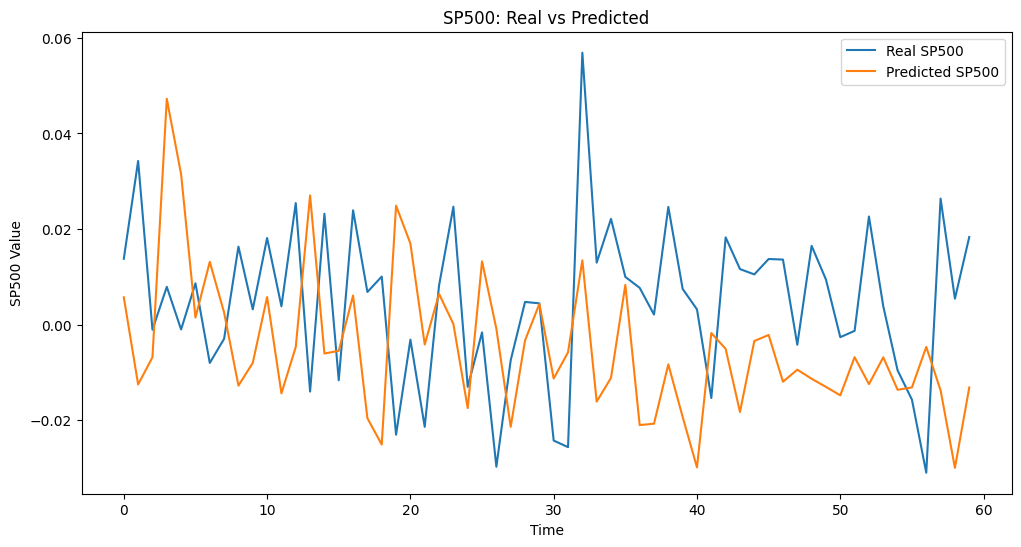

In [6]:
model.eval()
with torch.no_grad():
    preds = model(X_test).cpu().numpy()

sp500_real = y_scaler.inverse_transform(y_test.cpu().numpy())
sp500_pred = y_scaler.inverse_transform(preds)

plt.figure(figsize=(12, 6))
plt.plot(sp500_real, label='Real SP500')
plt.plot(sp500_pred, label='Predicted SP500')
plt.title('SP500: Real vs Predicted')
plt.xlabel('Time')
plt.ylabel('SP500 Value')
plt.legend()
plt.show()

In [7]:
real = sp500_real.flatten()
pred = sp500_pred.flatten()
real_diff = np.sign(np.diff(real))
pred_diff = np.sign(np.diff(pred))
mse = mean_squared_error(real, pred)
print(f"Mean Squared Error: {mse:.6f}")
directional_accuracy = np.mean(real_diff == pred_diff)
print(f"Directional Accuracy: {directional_accuracy:.2%}")

Mean Squared Error: 1.966102
Directional Accuracy: 50.85%


Epoch 1: Train=0.1113, Val=0.1228, Test=0.1399
Epoch 2: Train=0.0203, Val=0.0151, Test=0.0085
Epoch 3: Train=0.0122, Val=0.0185, Test=0.0110
Epoch 3: Train=0.0122, Val=0.0185, Test=0.0110
Epoch 4: Train=0.0100, Val=0.0125, Test=0.0043
Epoch 5: Train=0.0091, Val=0.0124, Test=0.0042
Epoch 4: Train=0.0100, Val=0.0125, Test=0.0043
Epoch 5: Train=0.0091, Val=0.0124, Test=0.0042
Epoch 6: Train=0.0091, Val=0.0134, Test=0.0066
Epoch 6: Train=0.0091, Val=0.0134, Test=0.0066
Epoch 7: Train=0.0088, Val=0.0124, Test=0.0049
Epoch 8: Train=0.0085, Val=0.0125, Test=0.0054
Epoch 9: Train=0.0097, Val=0.0124, Test=0.0038
Epoch 7: Train=0.0088, Val=0.0124, Test=0.0049
Epoch 8: Train=0.0085, Val=0.0125, Test=0.0054
Epoch 9: Train=0.0097, Val=0.0124, Test=0.0038
Epoch 10: Train=0.0086, Val=0.0136, Test=0.0041
Epoch 10: Train=0.0086, Val=0.0136, Test=0.0041
Epoch 11: Train=0.0125, Val=0.0120, Test=0.0047
Epoch 12: Train=0.0085, Val=0.0148, Test=0.0043
Epoch 11: Train=0.0125, Val=0.0120, Test=0.0047
Epoch 12

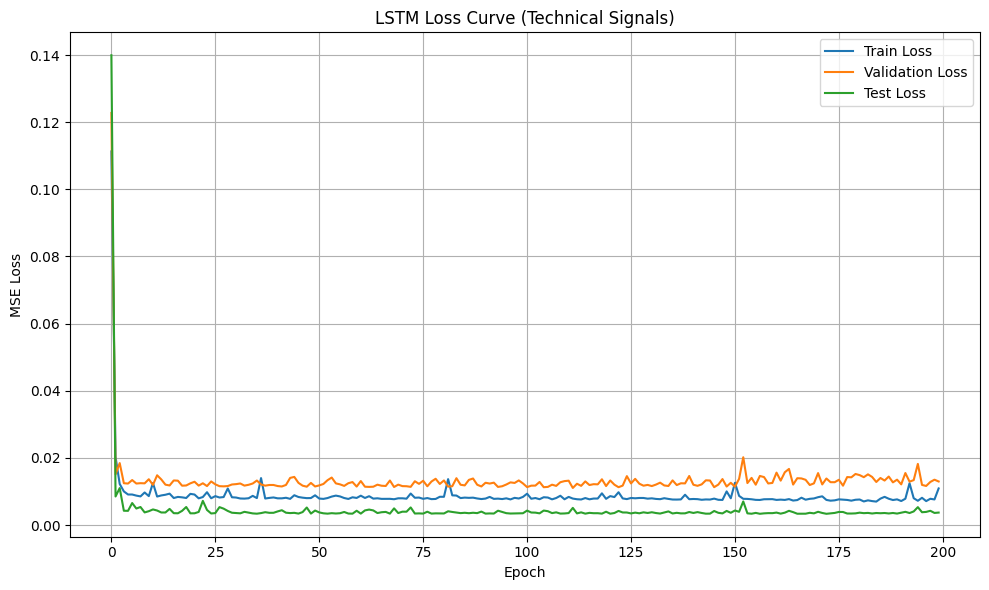

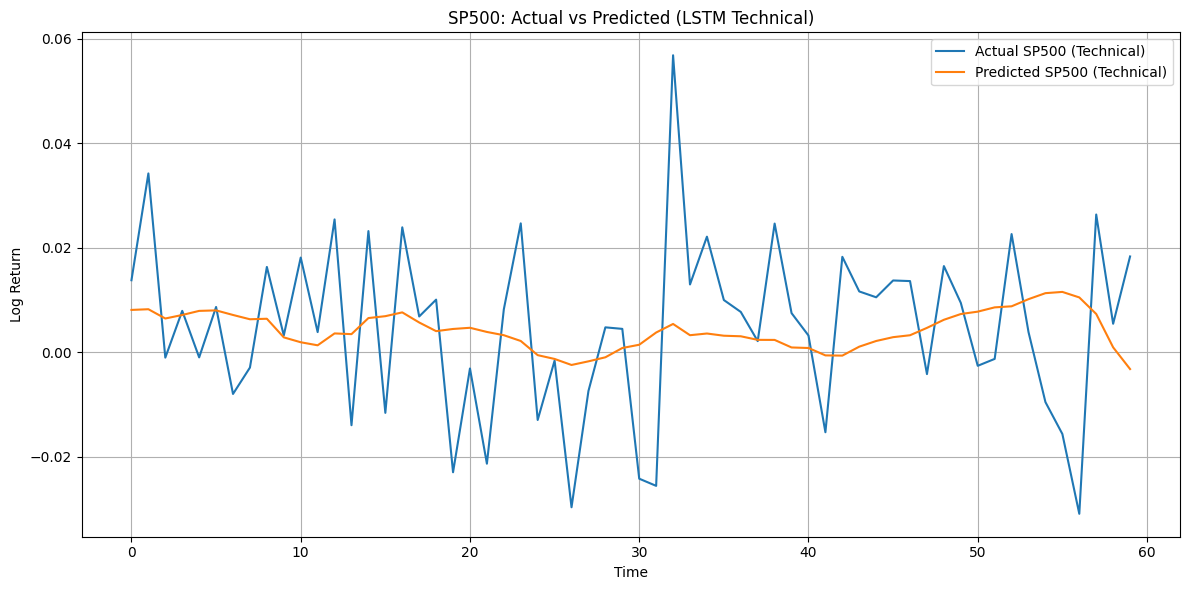

Directional Accuracy (Technical): 57.63%
Mean Squared Error: 1.694915


In [8]:

X_technical_seq_raw, y_technical_seq_raw = create_sequences(X_technical, y_technical, seq_length=20)

X_train_raw, y_train_raw, X_val_raw, y_val_raw, X_test_raw, y_test_raw = train_val_test_split(
    X_technical_seq_raw, y_technical_seq_raw
)

tech_scaler = MinMaxScaler()
X_train_flat = X_train_raw.reshape(-1, X_train_raw.shape[-1])
X_train_scaled = tech_scaler.fit_transform(X_train_flat).reshape(X_train_raw.shape)

X_val_scaled = tech_scaler.transform(X_val_raw.reshape(-1, X_val_raw.shape[-1])).reshape(X_val_raw.shape)
X_test_scaled = tech_scaler.transform(X_test_raw.reshape(-1, X_test_raw.shape[-1])).reshape(X_test_raw.shape)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train_raw)
y_val_scaled = y_scaler.transform(y_val_raw)
y_test_scaled = y_scaler.transform(y_test_raw)

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32)
X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_t = torch.tensor(y_val_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test_scaled, dtype=torch.float32)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.linear(out[:, -1, :])  


input_size_t = X_train_t.shape[2]
model_t = LSTMModel(input_size=input_size_t, hidden_size=64, output_size=1)

criterion_t = nn.MSELoss()
optimizer_t = torch.optim.Adam(model_t.parameters(), lr=0.001)

train_loader_t = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=16, shuffle=True)
val_loader_t = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=16)
test_loader_t = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=16, shuffle=False)

train_losses_t, val_losses_t, test_losses_t = [], [], []

for epoch in range(200):
    model_t.train()
    total_train_loss = 0
    for xb, yb in train_loader_t:
        optimizer_t.zero_grad()
        pred = model_t(xb)
        loss = criterion_t(pred.squeeze(), yb.squeeze())
        loss.backward()
        optimizer_t.step()
        total_train_loss += loss.item()
    train_losses_t.append(total_train_loss / len(train_loader_t))

    model_t.eval()
    with torch.no_grad():
        val_loss = sum(criterion_t(model_t(xb).squeeze(), yb.squeeze()).item() for xb, yb in val_loader_t) / len(val_loader_t)
        test_loss = sum(criterion_t(model_t(xb).squeeze(), yb.squeeze()).item() for xb, yb in test_loader_t) / len(test_loader_t)

    val_losses_t.append(val_loss)
    test_losses_t.append(test_loss)

    print(f"Epoch {epoch+1}: Train={train_losses_t[-1]:.4f}, Val={val_loss:.4f}, Test={test_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(train_losses_t, label='Train Loss')
plt.plot(val_losses_t, label='Validation Loss')
plt.plot(test_losses_t, label='Test Loss')
plt.title("LSTM Loss Curve (Technical Signals)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

model_t.eval()
with torch.no_grad():
    preds_t = model_t(X_test_t).cpu().numpy()

sp500_real_t = y_scaler.inverse_transform(y_test_t.cpu().numpy()).flatten()
sp500_pred_t = y_scaler.inverse_transform(preds_t).flatten()

plt.figure(figsize=(12, 6))
plt.plot(sp500_real_t, label='Actual SP500 (Technical)')
plt.plot(sp500_pred_t, label='Predicted SP500 (Technical)')
plt.title('SP500: Actual vs Predicted (LSTM Technical)')
plt.xlabel('Time')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

real_diff_t = np.sign(np.diff(sp500_real_t))
pred_diff_t = np.sign(np.diff(sp500_pred_t))
directional_accuracy_t = np.mean(real_diff_t == pred_diff_t)
print(f"Directional Accuracy (Technical): {directional_accuracy_t:.2%}")
mse = mean_squared_error(sp500_real_t, sp500_pred_t)
print(f"Mean Squared Error: {mse:.6f}")
torch.save(model_t, "lstm_model_technical_signals.pth")

Epoch 1: Train=0.2332, Val=0.1012, Test=0.1154
Epoch 2: Train=0.0266, Val=0.0326, Test=0.0390
Epoch 3: Train=0.0159, Val=0.0613, Test=0.0783
Epoch 4: Train=0.0109, Val=0.0332, Test=0.0382
Epoch 2: Train=0.0266, Val=0.0326, Test=0.0390
Epoch 3: Train=0.0159, Val=0.0613, Test=0.0783
Epoch 4: Train=0.0109, Val=0.0332, Test=0.0382
Epoch 5: Train=0.0101, Val=0.0269, Test=0.0268
Epoch 5: Train=0.0101, Val=0.0269, Test=0.0268
Epoch 6: Train=0.0089, Val=0.0322, Test=0.0311
Epoch 7: Train=0.0113, Val=0.0241, Test=0.0193
Epoch 8: Train=0.0099, Val=0.0216, Test=0.0148
Epoch 6: Train=0.0089, Val=0.0322, Test=0.0311
Epoch 7: Train=0.0113, Val=0.0241, Test=0.0193
Epoch 8: Train=0.0099, Val=0.0216, Test=0.0148
Epoch 9: Train=0.0088, Val=0.0178, Test=0.0094
Epoch 9: Train=0.0088, Val=0.0178, Test=0.0094
Epoch 10: Train=0.0104, Val=0.0219, Test=0.0130
Epoch 11: Train=0.0084, Val=0.0183, Test=0.0090
Epoch 10: Train=0.0104, Val=0.0219, Test=0.0130
Epoch 11: Train=0.0084, Val=0.0183, Test=0.0090
Epoch 12:

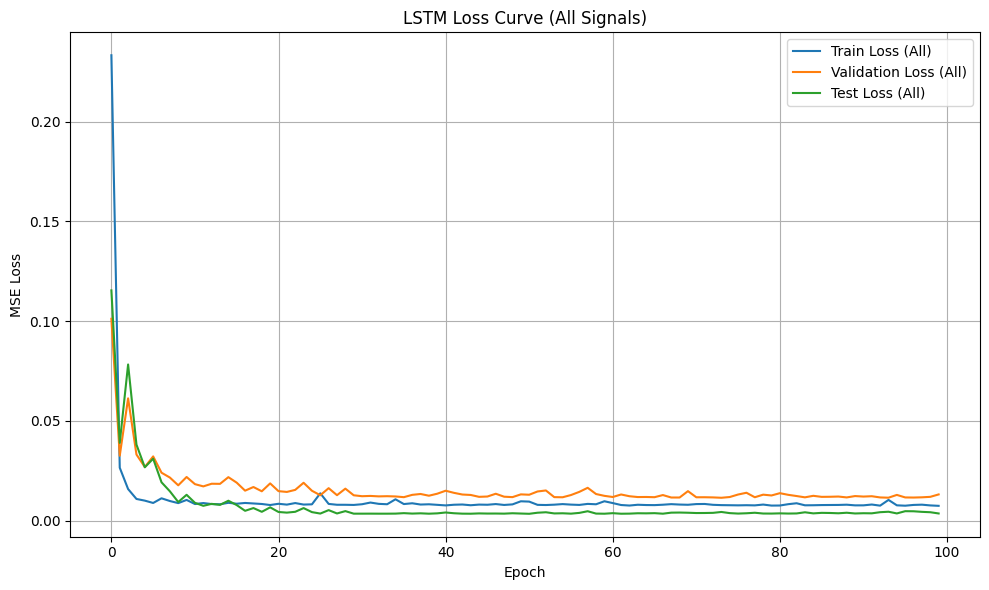

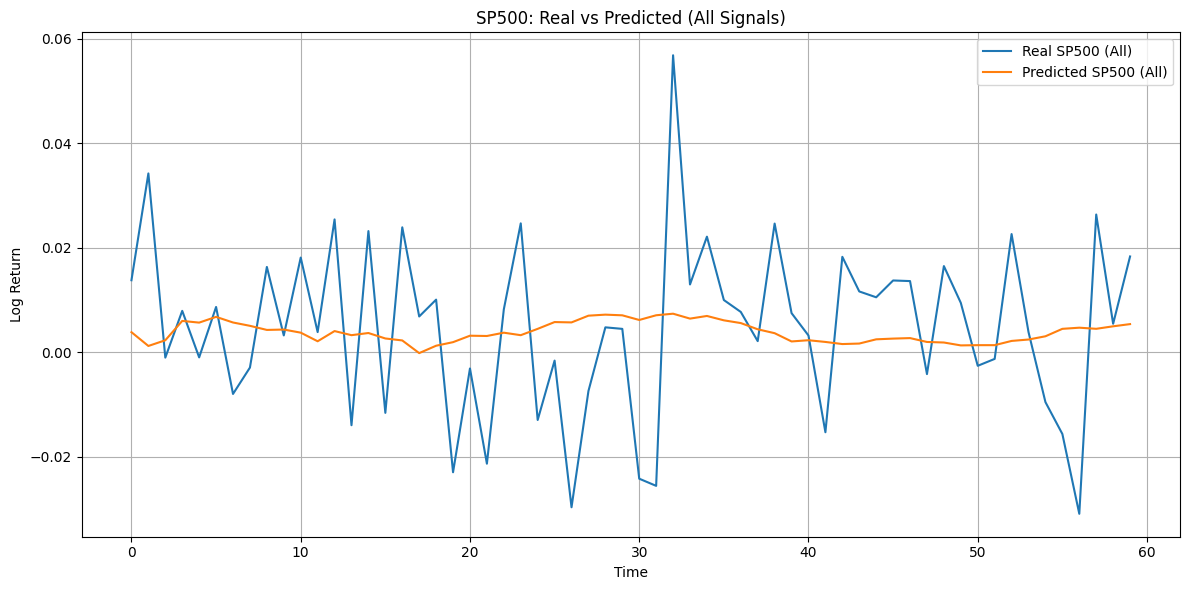

Directional Accuracy (All): 55.93%
Mean Squared Error: 1.762712


In [9]:
features = macro_features + technical_features
X_all = df[features].values
y_all = df[[target]].values

X_all_seq_raw, y_all_seq_raw = create_sequences(X_all, y_all, seq_length=20)

X_train_raw, y_train_raw, X_val_raw, y_val_raw, X_test_raw, y_test_raw = train_val_test_split(
    X_all_seq_raw, y_all_seq_raw
)

scaler_all = MinMaxScaler()
X_train_flat = X_train_raw.reshape(-1, X_train_raw.shape[-1])
X_train_scaled = scaler_all.fit_transform(X_train_flat).reshape(X_train_raw.shape)
X_val_scaled = scaler_all.transform(X_val_raw.reshape(-1, X_val_raw.shape[-1])).reshape(X_val_raw.shape)
X_test_scaled = scaler_all.transform(X_test_raw.reshape(-1, X_test_raw.shape[-1])).reshape(X_test_raw.shape)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train_raw)
y_val_scaled = y_scaler.transform(y_val_raw)
y_test_scaled = y_scaler.transform(y_test_raw)

X_train_all = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_all = torch.tensor(y_train_scaled, dtype=torch.float32)
X_val_all = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_all = torch.tensor(y_val_scaled, dtype=torch.float32)
X_test_all = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_all = torch.tensor(y_test_scaled, dtype=torch.float32)

input_size_all = X_train_all.shape[2]
model_all = LSTMModel(input_size=input_size_all, hidden_size=64, output_size=1)

criterion_all = nn.MSELoss()
optimizer_all = torch.optim.Adam(model_all.parameters(), lr=0.001)

train_loader_all = DataLoader(TensorDataset(X_train_all, y_train_all), batch_size=16, shuffle=True)
val_loader_all = DataLoader(TensorDataset(X_val_all, y_val_all), batch_size=16)
test_loader_all = DataLoader(TensorDataset(X_test_all, y_test_all), batch_size=16, shuffle=False)

train_losses_all, val_losses_all, test_losses_all = [], [], []

for epoch in range(100):
    model_all.train()
    total_train_loss = 0
    for xb, yb in train_loader_all:
        optimizer_all.zero_grad()
        pred = model_all(xb)
        loss = criterion_all(pred.squeeze(), yb.squeeze())
        loss.backward()
        optimizer_all.step()
        total_train_loss += loss.item()
    train_losses_all.append(total_train_loss / len(train_loader_all))

    model_all.eval()
    with torch.no_grad():
        val_loss = sum(criterion_all(model_all(xb).squeeze(), yb.squeeze()).item() for xb, yb in val_loader_all) / len(val_loader_all)
        test_loss = sum(criterion_all(model_all(xb).squeeze(), yb.squeeze()).item() for xb, yb in test_loader_all) / len(test_loader_all)
    val_losses_all.append(val_loss)
    test_losses_all.append(test_loss)

    print(f"Epoch {epoch+1}: Train={train_losses_all[-1]:.4f}, Val={val_loss:.4f}, Test={test_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(train_losses_all, label='Train Loss (All)')
plt.plot(val_losses_all, label='Validation Loss (All)')
plt.plot(test_losses_all, label='Test Loss (All)')
plt.title("LSTM Loss Curve (All Signals)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

model_all.eval()
with torch.no_grad():
    preds_all = model_all(X_test_all).cpu().numpy()

sp500_real_all = y_scaler.inverse_transform(y_test_all.cpu().numpy()).flatten()
sp500_pred_all = y_scaler.inverse_transform(preds_all).flatten()

plt.figure(figsize=(12, 6))
plt.plot(sp500_real_all, label='Real SP500 (All)')
plt.plot(sp500_pred_all, label='Predicted SP500 (All)')
plt.title('SP500: Real vs Predicted (All Signals)')
plt.xlabel('Time')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

real_diff_all = np.sign(np.diff(sp500_real_all))
pred_diff_all = np.sign(np.diff(sp500_pred_all))
directional_accuracy_all = np.mean(real_diff_all == pred_diff_all)
print(f"Directional Accuracy (All): {directional_accuracy_all:.2%}")
mse = mean_squared_error(sp500_real_all, sp500_pred_all)
print(f"Mean Squared Error: {mse:.6f}")
torch.save(model_all, "lstm_model_all_signals.pth")
